In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
from sklearn import tree # for decision tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [6]:
from sklearn.inspection import permutation_importance

In [7]:
# Read in the malnutrition data csv
df=pd.read_csv('/content/drive/MyDrive/Sifat Sir Work /malnutrition dataset 25-09-24.csv', encoding='utf-8')
df.head()

,year,residence,wealth_index,highest_edu_level,partners_edu_lvl,no_visits,age_at_1st_birth,child_sex,age_child,bord,...,birth_in_3years,toilet_facilities,householdhead_sex,child_twin,duration_breastfeeding,delivery_caesarian,respondent_currently_working,exposure_mass_media,bmi_cat,ciafl
0,7,2,6,1,1,1,2,2,2,1,...,1,0,1,0,3,0,0,0,1,0
1,7,2,6,0,0,1,1,1,2,3,...,1,0,1,0,95,0,0,0,2,3
2,7,2,6,1,0,1,3,1,2,1,...,0,0,1,0,3,0,0,0,2,3
3,7,2,6,0,1,1,2,2,2,2,...,0,1,2,0,95,0,0,0,1,0
4,7,2,6,1,2,1,3,1,1,3,...,2,0,1,0,95,0,0,0,1,2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21404 entries, 0 to 21403
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   year                          21404 non-null  int64
 1   residence                     21404 non-null  int64
 2   wealth_index                  21404 non-null  int64
 3   highest_edu_level             21404 non-null  int64
 4   partners_edu_lvl              21404 non-null  int64
 5   no_visits                     21404 non-null  int64
 6   age_at_1st_birth              21404 non-null  int64
 7   child_sex                     21404 non-null  int64
 8   age_child                     21404 non-null  int64
 9   bord                          21404 non-null  int64
 10  no_under5                     21404 non-null  int64
 11  source_water                  21404 non-null  int64
 12  birth_in_3years               21404 non-null  int64
 13  toilet_facilities             2

In [9]:
year = df['year'].value_counts(normalize=True).rename("Observation").sort_index().reset_index()
replacements = {7: "2007", 11: "2011", 14: "2014", 17: "2017", 2022: "2022", }
year["year"]= year["year"].apply(lambda x: replacements.get(x, x)).astype(str)

**Observation by Year**

- **SF1 = based on Chi-square Test**
- **SF2 = based on Burota Algorithm**
- **SF2 = based on Mutual Importance**


# With imbalanaced Dataset

In [10]:
#target = "ciafl"

df1 = df.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])
df2 = df.drop(columns=["child_sex","source_water","toilet_facilities","child_twin", "no_under5", "bmi_cat"])
df3 = df.drop(columns=["age_at_1st_birth", "child_sex","toilet_facilities","bord","residence",
                      "exposure_mass_media", "householdhead_sex","respondent_currently_working","source_water",
                      "no_visits","child_twin", "bmi_cat"])
print(df1.shape)
print(df2.shape)
print(df3.shape)

(21404, 16)
(21404, 16)
(21404, 10)


In [11]:
print(df1.columns)
print(df2.columns)
print(df3.columns)

Index(['year', 'residence', 'wealth_index', 'highest_edu_level',
       'partners_edu_lvl', 'age_at_1st_birth', 'age_child', 'bord',
       'no_under5', 'birth_in_3years', 'toilet_facilities', 'child_twin',
       'duration_breastfeeding', 'delivery_caesarian', 'exposure_mass_media',
       'ciafl'],
      dtype='object')
Index(['year', 'residence', 'wealth_index', 'highest_edu_level',
       'partners_edu_lvl', 'no_visits', 'age_at_1st_birth', 'age_child',
       'bord', 'birth_in_3years', 'householdhead_sex',
       'duration_breastfeeding', 'delivery_caesarian',
       'respondent_currently_working', 'exposure_mass_media', 'ciafl'],
      dtype='object')
Index(['year', 'wealth_index', 'highest_edu_level', 'partners_edu_lvl',
       'age_child', 'no_under5', 'birth_in_3years', 'duration_breastfeeding',
       'delivery_caesarian', 'ciafl'],
      dtype='object')


In [12]:
train_data1 = df1[df1.iloc[:,0]!= 2022]
test_data1 = df1[df1.iloc[:,0]== 2022]
train_data2 = df2[df2.iloc[:,0]!= 2022]
test_data2 = df2[df2.iloc[:,0]== 2022]
train_data3 = df3[df3.iloc[:,0]!= 2022]
test_data3 = df3[df3.iloc[:,0]== 2022]

In [13]:
target = "ciafl"
X1_train = train_data1.drop(columns=target)
X1_test = test_data1.drop(columns=target)
y_train = train_data1[target]
y_test = test_data1[target]

In [14]:
target = "ciafl"
X2_train = train_data2.drop(columns=target)
X2_test = test_data2.drop(columns=target)
y_train = train_data2[target]
y_test = test_data2[target]

In [15]:
target = "ciafl"
X3_train = train_data3.drop(columns=target)
X3_test = test_data3.drop(columns=target)
y_train = train_data3[target]
y_test = test_data3[target]

### Model building

In [ ]:
seed = 42
models = [DecisionTreeClassifier(random_state=42),
          KNeighborsClassifier(),
          GaussianNB(),
          RandomForestClassifier(random_state=seed),
          AdaBoostClassifier(random_state=seed),
          GradientBoostingClassifier(random_state=seed),
          xgb.XGBClassifier(objective="multi:softmax",random_state=seed),
          ]

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
def compare_models(A, B):
  for model in models:

    # training the model
    model.fit(A, y_train)

    # evaluating the model
    test_data_prediction = model.predict(B)
    accuracy = accuracy_score(y_test, test_data_prediction)


    accuracy_scores.append(accuracy)
    precision_scores.append(precision_score(y_test, test_data_prediction, average='weighted'))
    recall_scores.append(recall_score(y_test, test_data_prediction, average='weighted'))
    f1_scores.append(f1_score(y_test, test_data_prediction, average='weighted'))

    print('Accuracy score of the ', model, ' = ', accuracy)
    print('----------------------------------------------')
    #print classification report for model
    print(classification_report(y_test, test_data_prediction))
    print('----------------------------------------------')

In [ ]:
compare_models(X1_train, X1_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.5035211267605634
----------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      1512
           1       0.00      0.00      0.00        68
           2       0.19      0.08      0.11       110
           3       0.02      0.02      0.02        65
           4       0.11      0.11      0.11       231
           5       0.12      0.17      0.14       226
           6       0.00      0.00      0.00        60

    accuracy                           0.50      2272
   macro avg       0.16      0.16      0.15      2272
weighted avg       0.49      0.50      0.49      2272

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.6183978873239436
----------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.91      0.78      151

In [ ]:
# With Chi square features

model_performance1 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance1

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.503521,0.487927,0.503521,0.494191
1,KNN,0.618398,0.477736,0.618398,0.532395
2,Naive Bayes,0.665493,0.442881,0.665493,0.531832
3,RandomForest,0.585827,0.473158,0.585827,0.520628
4,Adaboost,0.665493,0.442881,0.665493,0.531832
5,Gradiant_boosting,0.664613,0.442685,0.664613,0.531409
6,XGBoost,0.657570,0.501156,0.657570,0.546942


In [ ]:
print(accuracy_scores)
print(precision_scores)
print(recall_scores)
print(f1_scores)


[0.5035211267605634, 0.6183978873239436, 0.6654929577464789, 0.5858274647887324, 0.6654929577464789, 0.664612676056338, 0.6575704225352113]
[0.4879271498025856, 0.4777359456671669, 0.44288087681015675, 0.4731584459330508, 0.44288087681015675, 0.44268474281814235, 0.5011561571262437]
[0.5035211267605634, 0.6183978873239436, 0.6654929577464789, 0.5858274647887324, 0.6654929577464789, 0.664612676056338, 0.6575704225352113]
[0.49419076774995685, 0.5323954120712403, 0.5318315814549028, 0.5206280159994224, 0.5318315814549028, 0.5314089720767758, 0.5469419222059528]


In [ ]:
# With Boruta Features
model_performance2 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance2

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.503521,0.487927,0.503521,0.494191
1,KNN,0.618398,0.477736,0.618398,0.532395
2,Naive Bayes,0.665493,0.442881,0.665493,0.531832
3,RandomForest,0.585827,0.473158,0.585827,0.520628
4,Adaboost,0.665493,0.442881,0.665493,0.531832
5,Gradiant_boosting,0.664613,0.442685,0.664613,0.531409
6,XGBoost,0.657570,0.501156,0.657570,0.546942


In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
compare_models(X3_train, X3_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.6285211267605634
----------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.93      0.78      1512
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00       110
           3       0.12      0.03      0.05        65
           4       0.14      0.05      0.08       231
           5       0.14      0.04      0.06       226
           6       0.00      0.00      0.00        60

    accuracy                           0.63      2272
   macro avg       0.15      0.15      0.14      2272
weighted avg       0.48      0.63      0.54      2272

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.6377640845070423
----------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.95      0.79      151

In [ ]:
# With Mutual algorithm Features

model_performance3 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance3

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.628521,0.480094,0.628521,0.535075
1,KNN,0.637764,0.487547,0.637764,0.537322
2,Naive Bayes,0.665493,0.442881,0.665493,0.531832
3,RandomForest,0.629842,0.481404,0.629842,0.536923
4,Adaboost,0.665493,0.442881,0.665493,0.531832
5,Gradiant_boosting,0.665053,0.508021,0.665053,0.533769
6,XGBoost,0.656250,0.481950,0.656250,0.539529


# Reviewer Approach (Split test and train data from each year)

In [ ]:
# Read in the malnutrition data csv
df=pd.read_csv('/content/drive/MyDrive/Sifat Sir Work /malnutrition dataset 25-09-24.csv', encoding='utf-8')
df.head()

,year,residence,wealth_index,highest_edu_level,partners_edu_lvl,no_visits,age_at_1st_birth,child_sex,age_child,bord,...,birth_in_3years,toilet_facilities,householdhead_sex,child_twin,duration_breastfeeding,delivery_caesarian,respondent_currently_working,exposure_mass_media,bmi_cat,ciafl
0,7,2,6,1,1,1,2,2,2,1,...,1,0,1,0,3,0,0,0,1,0
1,7,2,6,0,0,1,1,1,2,3,...,1,0,1,0,95,0,0,0,2,3
2,7,2,6,1,0,1,3,1,2,1,...,0,0,1,0,3,0,0,0,2,3
3,7,2,6,0,1,1,2,2,2,2,...,0,1,2,0,95,0,0,0,1,0
4,7,2,6,1,2,1,3,1,1,3,...,2,0,1,0,95,0,0,0,1,2


In [ ]:
year = df['year'].value_counts(normalize=True).rename("Observation").sort_index().reset_index()
replacements = {7: "2007", 11: "2011", 14: "2014", 17: "2017", 2022: "2022", }
year["year"]= year["year"].apply(lambda x: replacements.get(x, x)).astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

# Initialize empty DataFrames to store the combined train and test data
train_list = []
test_list = []

# Group by the 'year' column and filter out years with only one sample
for year in df['year'].unique():
    year_data = df[df['year'] == year]

    if len(year_data) > 1: # Only split if there is more than one sample
        # Split the data into train and test (70% train, 30% test)
        X_train, X_test, y_train, y_test = train_test_split(
            year_data.drop('ciafl', axis=1),
            year_data['ciafl'],
            test_size=0.3,
            train_size=0.7,
            random_state=42
        )

        # Combine the train and test sets for the current year
        train_split = X_train.copy()
        train_split['ciafl'] = y_train
        test_split = X_test.copy()
        test_split['ciafl'] = y_test

        # Append to the list
        train_list.append(train_split)
        test_list.append(test_split)

# Concatenate the splits for all years into the final train and test datasets
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Shuffle the final train and test datasets (optional, but good for model generalization)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#target = "ciafl"

train_df1 = train_df.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])
test_df1 = test_df.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])

train_df2 = train_df.drop(columns=["child_sex","source_water","toilet_facilities","child_twin", "no_under5", "bmi_cat"])
test_df2 = test_df.drop(columns=["child_sex","source_water","toilet_facilities","child_twin", "no_under5", "bmi_cat"])

train_df3 = train_df.drop(columns=["age_at_1st_birth", "child_sex","toilet_facilities","bord","residence",
                      "exposure_mass_media", "householdhead_sex","respondent_currently_working","source_water",
                      "no_visits","child_twin", "bmi_cat"])
test_df3 = test_df.drop(columns=["age_at_1st_birth", "child_sex","toilet_facilities","bord","residence",
                      "exposure_mass_media", "householdhead_sex","respondent_currently_working","source_water",
                      "no_visits","child_twin", "bmi_cat"])


In [ ]:
train_data1=train_df1
test_data1=test_df1
train_data2=train_df2
test_data2=test_df2
train_data3=train_df3
test_data3=test_df3

In [ ]:
target = "ciafl"
X1_train = train_data1.drop(columns=target)
X1_test = test_data1.drop(columns=target)
y_train = train_data1[target]
y_test = test_data1[target]

In [ ]:
target = "ciafl"
X2_train = train_data2.drop(columns=target)
X2_test = test_data2.drop(columns=target)
y_train = train_data2[target]
y_test = test_data2[target]

In [ ]:
target = "ciafl"
X3_train = train_data3.drop(columns=target)
X3_test = test_data3.drop(columns=target)
y_train = train_data3[target]
y_test = test_data3[target]

### Model building

In [ ]:
seed = 42
models = [DecisionTreeClassifier(random_state=42),
          KNeighborsClassifier(),
          GaussianNB(),
          RandomForestClassifier(random_state=seed),
          AdaBoostClassifier(random_state=seed),
          GradientBoostingClassifier(random_state=seed),
          xgb.XGBClassifier(objective="multi:softmax",random_state=seed),
          ]

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
def compare_models(A, B):
  for model in models:

    # training the model
    model.fit(A, y_train)

    # evaluating the model
    test_data_prediction = model.predict(B)
    accuracy = accuracy_score(y_test, test_data_prediction)


    accuracy_scores.append(accuracy)
    precision_scores.append(precision_score(y_test, test_data_prediction, average='weighted'))
    recall_scores.append(recall_score(y_test, test_data_prediction, average='weighted'))
    f1_scores.append(f1_score(y_test, test_data_prediction, average='weighted'))

    print('Accuracy score of the ', model, ' = ', accuracy)
    print('----------------------------------------------')
    #print classification report for model
    print(classification_report(y_test, test_data_prediction))
    print('----------------------------------------------')

In [ ]:
compare_models(X1_train, X1_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.3894425412644036
----------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.62      0.59      3378
           1       0.02      0.02      0.02       171
           2       0.04      0.04      0.04       354
           3       0.08      0.07      0.07       367
           4       0.23      0.20      0.22      1093
           5       0.16      0.14      0.15       873
           6       0.05      0.03      0.04       186

    accuracy                           0.39      6422
   macro avg       0.16      0.16      0.16      6422
weighted avg       0.37      0.39      0.38      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.48878853939582684
----------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.85      0.67      33

In [ ]:
model_performance1 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance1

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.389443,0.369304,0.389443,0.378414
1,KNN,0.488789,0.371450,0.488789,0.405592
2,Naive Bayes,0.495640,0.369602,0.495640,0.415024
3,RandomForest,0.464341,0.367157,0.464341,0.399856
4,Adaboost,0.532389,0.348738,0.532389,0.401772
5,Gradiant_boosting,0.532700,0.390267,0.532700,0.405116
6,XGBoost,0.522267,0.384000,0.522267,0.412699


In [ ]:
print(accuracy_scores)
print(precision_scores)
print(recall_scores)
print(f1_scores)

[0.3894425412644036, 0.48878853939582684, 0.49563998754282157, 0.46434132668950484, 0.5323886639676113, 0.5327000934288384, 0.5222672064777328]
[0.36930376609897436, 0.3714501389132109, 0.36960240405561423, 0.3671573625063502, 0.3487384934924749, 0.39026719041099694, 0.3839998624942555]
[0.3894425412644036, 0.48878853939582684, 0.49563998754282157, 0.46434132668950484, 0.5323886639676113, 0.5327000934288384, 0.5222672064777328]
[0.37841435719506056, 0.40559229158852345, 0.41502356121567835, 0.399856454335522, 0.40177157959889376, 0.4051156534709957, 0.4126990139734769]


In [ ]:
model_performance2 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance2

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.389443,0.369304,0.389443,0.378414
1,KNN,0.488789,0.371450,0.488789,0.405592
2,Naive Bayes,0.495640,0.369602,0.495640,0.415024
3,RandomForest,0.464341,0.367157,0.464341,0.399856
4,Adaboost,0.532389,0.348738,0.532389,0.401772
5,Gradiant_boosting,0.532700,0.390267,0.532700,0.405116
6,XGBoost,0.522267,0.384000,0.522267,0.412699


In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
compare_models(X3_train, X3_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.4971971348489567
----------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.87      0.68      3378
           1       0.06      0.01      0.02       171
           2       0.07      0.02      0.03       354
           3       0.11      0.05      0.07       367
           4       0.29      0.15      0.20      1093
           5       0.20      0.05      0.09       873
           6       0.04      0.01      0.01       186

    accuracy                           0.50      6422
   macro avg       0.19      0.17      0.16      6422
weighted avg       0.38      0.50      0.41      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.48909996885705387
----------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.85      0.67      33

In [ ]:
model_performance3 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance3

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.497197,0.382753,0.497197,0.409711
1,KNN,0.489100,0.371659,0.489100,0.406970
2,Naive Bayes,0.494706,0.373274,0.494706,0.415197
3,RandomForest,0.500779,0.385230,0.500779,0.416373
4,Adaboost,0.529274,0.342878,0.529274,0.386532
5,Gradiant_boosting,0.529430,0.382991,0.529430,0.402809
6,XGBoost,0.525070,0.385023,0.525070,0.407052


# Reviewer Approach (Year Wise) + Add smote to training dataset

In [ ]:
# Read in the malnutrition data csv
df=pd.read_csv('/content/drive/MyDrive/Sifat Sir Work /malnutrition dataset 25-09-24.csv', encoding='utf-8')

In [ ]:
year = df['year'].value_counts(normalize=True).rename("Observation").sort_index().reset_index()
replacements = {7: "2007", 11: "2011", 14: "2014", 17: "2017", 2022: "2022", }
year["year"]= year["year"].apply(lambda x: replacements.get(x, x)).astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

# Initialize empty DataFrames to store the combined train and test data
train_list = []
test_list = []

# Group by the 'year' column and filter out years with only one sample
for year in df['year'].unique():
    year_data = df[df['year'] == year]

    if len(year_data) > 1: # Only split if there is more than one sample
        # Split the data into train and test (70% train, 30% test)
        X_train, X_test, y_train, y_test = train_test_split(
            year_data.drop('ciafl', axis=1),
            year_data['ciafl'],
            test_size=0.3,
            train_size=0.7,
            random_state=42
        )

        # Combine the train and test sets for the current year
        train_split = X_train.copy()
        train_split['ciafl'] = y_train
        test_split = X_test.copy()
        test_split['ciafl'] = y_test

        # Append to the list
        train_list.append(train_split)
        test_list.append(test_split)

# Concatenate the splits for all years into the final train and test datasets
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Shuffle the final train and test datasets (optional, but good for model generalization)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#target = "ciafl"

train_df1 = train_df.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])
test_df1 = test_df.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])

train_df2 = train_df.drop(columns=["child_sex","source_water","toilet_facilities","child_twin", "no_under5", "bmi_cat"])
test_df2 = test_df.drop(columns=["child_sex","source_water","toilet_facilities","child_twin", "no_under5", "bmi_cat"])

train_df3 = train_df.drop(columns=["age_at_1st_birth", "child_sex","toilet_facilities","bord","residence",
                      "exposure_mass_media", "householdhead_sex","respondent_currently_working","source_water",
                      "no_visits","child_twin", "bmi_cat"])
test_df3 = test_df.drop(columns=["age_at_1st_birth", "child_sex","toilet_facilities","bord","residence",
                      "exposure_mass_media", "householdhead_sex","respondent_currently_working","source_water",
                      "no_visits","child_twin", "bmi_cat"])


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train1 = train_df1.drop(columns="ciafl")
y_train1 = train_df1['ciafl']
y_test1=test_df1['ciafl']
x_test1 = test_df1.drop(columns="ciafl")

X_train2 = train_df2.drop(columns="ciafl")
y_train2 = train_df2['ciafl']
y_test2=test_df2['ciafl']
x_test2 = test_df2.drop(columns="ciafl")

X_train3 = train_df3.drop(columns="ciafl")
y_train3 = train_df3['ciafl']
y_test3=test_df3['ciafl']
x_test3 = test_df3.drop(columns="ciafl")

In [ ]:
sm = SMOTE(random_state=42)
X_train1_resampled, y_train1_resampled = sm.fit_resample(X_train1, y_train1)
X_train2_resampled, y_train2_resampled = sm.fit_resample(X_train2, y_train2)
X_train3_resampled, y_train3_resampled = sm.fit_resample(X_train3, y_train3)

In [ ]:
# To short the Model run time
sample_X_train1=X_train1_resampled.sample(frac=0.1, random_state=42)
sample_y_train1=y_train1_resampled.sample(frac=0.1, random_state=42)
sample_X_train2=X_train2_resampled.sample(frac=0.1, random_state=42)
sample_y_train2=y_train2_resampled.sample(frac=0.1, random_state=42)
sample_X_train3=X_train3_resampled.sample(frac=0.1, random_state=42)
sample_y_train3=y_train3_resampled.sample(frac=0.1, random_state=42)

In [ ]:
seed = 42
models = [DecisionTreeClassifier(random_state=42),
          KNeighborsClassifier(),
          GaussianNB(),
          RandomForestClassifier(random_state=seed),
          AdaBoostClassifier(random_state=seed),
          GradientBoostingClassifier(random_state=seed),
          xgb.XGBClassifier(objective="multi:softmax",random_state=seed),
          ]

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
def compare_models(X_train_data, X_test_data, y_train_data, y_test_data):
  for model in models:

    # training the model
    model.fit(X_train_data, y_train_data)

    # evaluating the model
    test_data_prediction = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, test_data_prediction)


    accuracy_scores.append(accuracy)
    precision_scores.append(precision_score(y_test_data, test_data_prediction, average='weighted'))
    recall_scores.append(recall_score(y_test_data, test_data_prediction, average='weighted'))
    f1_scores.append(f1_score(y_test_data, test_data_prediction, average='weighted'))

    print('Accuracy score of the ', model, ' = ', accuracy)
    print('----------------------------------------------')
    #print classification report for model
    print(classification_report(y_test_data, test_data_prediction))
    print('----------------------------------------------')

In [ ]:
compare_models(sample_X_train1, x_test1, sample_y_train1, y_test1)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.24026782933665525
----------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.30      0.40      3378
           1       0.05      0.17      0.07       171
           2       0.06      0.13      0.08       354
           3       0.09      0.17      0.11       367
           4       0.21      0.20      0.20      1093
           5       0.18      0.18      0.18       873
           6       0.03      0.10      0.04       186

    accuracy                           0.24      6422
   macro avg       0.17      0.18      0.16      6422
weighted avg       0.39      0.24      0.28      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.2398006851448147
----------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.32      0.43      33

In [ ]:
model_performance1 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance1

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.240268,0.388573,0.240268,0.284045
1,KNN,0.239801,0.405929,0.239801,0.289094
2,Naive Bayes,0.258019,0.428197,0.258019,0.286882
3,RandomForest,0.272501,0.394133,0.272501,0.314819
4,Adaboost,0.297415,0.424273,0.297415,0.337979
5,Gradiant_boosting,0.314232,0.411575,0.314232,0.352230
6,XGBoost,0.288384,0.394176,0.288384,0.327514


In [ ]:
# With Chi square features

model_performance1 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance1

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.240268,0.388573,0.240268,0.284045
1,KNN,0.239801,0.405929,0.239801,0.289094
2,Naive Bayes,0.258019,0.428197,0.258019,0.286882
3,RandomForest,0.272501,0.394133,0.272501,0.314819
4,Adaboost,0.297415,0.424273,0.297415,0.337979
5,Gradiant_boosting,0.314232,0.411575,0.314232,0.352230
6,XGBoost,0.288384,0.394176,0.288384,0.327514


In [ ]:
print(accuracy_scores)
print(precision_scores)
print(recall_scores)
print(f1_scores)


[0.24026782933665525, 0.2398006851448147, 0.25801930862659606, 0.27250077857365307, 0.29741513547181564, 0.31423232637807536, 0.2883836810962317]
[0.3885726533501402, 0.40592933239179085, 0.42819735479236365, 0.39413337111085806, 0.424273231708184, 0.4115751784704954, 0.3941761035497042]
[0.24026782933665525, 0.2398006851448147, 0.25801930862659606, 0.27250077857365307, 0.29741513547181564, 0.31423232637807536, 0.2883836810962317]
[0.2840454851597058, 0.2890940822818342, 0.2868824275192594, 0.31481893861557275, 0.3379791523410408, 0.35222980624181244, 0.3275141180647209]


In [ ]:
# With Boruta Features
model_performance2 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance2

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.240268,0.388573,0.240268,0.284045
1,KNN,0.239801,0.405929,0.239801,0.289094
2,Naive Bayes,0.258019,0.428197,0.258019,0.286882
3,RandomForest,0.272501,0.394133,0.272501,0.314819
4,Adaboost,0.297415,0.424273,0.297415,0.337979
5,Gradiant_boosting,0.314232,0.411575,0.314232,0.352230
6,XGBoost,0.288384,0.394176,0.288384,0.327514


In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
compare_models(sample_X_train3, x_test3, sample_y_train3, y_test3)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.22173777639364683
----------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.29      0.39      3378
           1       0.03      0.18      0.05       171
           2       0.06      0.14      0.08       354
           3       0.09      0.20      0.12       367
           4       0.25      0.16      0.19      1093
           5       0.14      0.12      0.13       873
           6       0.03      0.11      0.05       186

    accuracy                           0.22      6422
   macro avg       0.17      0.17      0.15      6422
weighted avg       0.39      0.22      0.27      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.23154780442229836
----------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.32      0.42      3

In [ ]:
# With Mutual algorithm Features

model_performance3 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance3

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.221738,0.391091,0.221738,0.270354
1,KNN,0.231548,0.395517,0.231548,0.280989
2,Naive Bayes,0.276549,0.416204,0.276549,0.312853
3,RandomForest,0.214419,0.401457,0.214419,0.262254
4,Adaboost,0.261601,0.431325,0.261601,0.311941
5,Gradiant_boosting,0.238399,0.433271,0.238399,0.288897
6,XGBoost,0.216132,0.408519,0.216132,0.265894


# Only SMOTE to training data

In [ ]:
# Read in the malnutrition data csv
data=pd.read_csv('/content/drive/MyDrive/Sifat Sir Work /malnutrition dataset 25-09-24.csv', encoding='utf-8')
data.head()

,year,residence,wealth_index,highest_edu_level,partners_edu_lvl,no_visits,age_at_1st_birth,child_sex,age_child,bord,...,birth_in_3years,toilet_facilities,householdhead_sex,child_twin,duration_breastfeeding,delivery_caesarian,respondent_currently_working,exposure_mass_media,bmi_cat,ciafl
0,7,2,6,1,1,1,2,2,2,1,...,1,0,1,0,3,0,0,0,1,0
1,7,2,6,0,0,1,1,1,2,3,...,1,0,1,0,95,0,0,0,2,3
2,7,2,6,1,0,1,3,1,2,1,...,0,0,1,0,3,0,0,0,2,3
3,7,2,6,0,1,1,2,2,2,2,...,0,1,2,0,95,0,0,0,1,0
4,7,2,6,1,2,1,3,1,1,3,...,2,0,1,0,95,0,0,0,1,2


In [ ]:
df1 = data.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])
df2 = data.drop(columns=["child_sex","source_water","toilet_facilities","child_twin", "no_under5", "bmi_cat"])
df3 = data.drop(columns=["age_at_1st_birth", "child_sex","toilet_facilities","bord","residence",
                      "exposure_mass_media", "householdhead_sex","respondent_currently_working","source_water",
                      "no_visits","child_twin", "bmi_cat"])
print(df1.shape)
print(df2.shape)
print(df3.shape)

(21404, 16)
(21404, 16)
(21404, 10)


In [ ]:
X_chi = df1.drop('ciafl', axis=1)
y_chi = df1['ciafl']
X_Bor = df2.drop('ciafl', axis=1)
y_Bor = df2['ciafl']
X_MU = df3.drop('ciafl', axis=1)
y_MU = df3['ciafl']

# Split Data
X_chi_train, X_chi_test, y_chi_train, y_chi_test = train_test_split(X_chi, y_chi, test_size=0.3, random_state=42, stratify=y)
X_Bor_train, X_Bor_test, y_Bor_train, y_Bor_test = train_test_split(X_Bor, y_Bor, test_size=0.3, random_state=42, stratify=y)
X_MU_train, X_MU_test, y_MU_train, y_MU_test = train_test_split(X_MU, y_MU, test_size=0.3, random_state=42, stratify=y)



# Handle Imbalance + Scaling
sm = SMOTE(random_state=42)
X_chi_train, y_chi_train = sm.fit_resample(X_chi_train, y_chi_train)
X_Bor_train, y_Bor_train = sm.fit_resample(X_Bor_train, y_Bor_train)
X_MU_train, y_MU_train = sm.fit_resample(X_MU_train, y_MU_train)

In [ ]:
# To short the Model run time
sample_X_chi_train=X_chi_train.sample(frac=0.1, random_state=42)
sample_y_chi_train=y_chi_train.sample(frac=0.1, random_state=42)
sample_X_Bor_train=X_Bor_train.sample(frac=0.1, random_state=42)
sample_y_Bor_train=y_Bor_train.sample(frac=0.1, random_state=42)
sample_X_MU_train=X_MU_train.sample(frac=0.1, random_state=42)
sample_y_MU_train=y_MU_train.sample(frac=0.1, random_state=42)

In [ ]:
seed = 42
models = [DecisionTreeClassifier(random_state=42),
          KNeighborsClassifier(),
          GaussianNB(),
          RandomForestClassifier(random_state=seed),
          AdaBoostClassifier(random_state=seed),
          GradientBoostingClassifier(random_state=seed),
          xgb.XGBClassifier(objective="multi:softmax",random_state=seed),
          ]

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
def compare_models(X_train_data, X_test_data, y_train_data, y_test_data):
  for model in models:

    # training the model
    model.fit(X_train_data, y_train_data)

    # evaluating the model
    test_data_prediction = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, test_data_prediction)


    accuracy_scores.append(accuracy)
    precision_scores.append(precision_score(y_test_data, test_data_prediction, average='weighted'))
    recall_scores.append(recall_score(y_test_data, test_data_prediction, average='weighted'))
    f1_scores.append(f1_score(y_test_data, test_data_prediction, average='weighted'))

    print('Accuracy score of the ', model, ' = ', accuracy)
    print('----------------------------------------------')
    #print classification report for model
    print(classification_report(y_test_data, test_data_prediction))
    print('----------------------------------------------')

In [ ]:
compare_models(sample_X_chi_train, X_chi_test, sample_y_chi_train, y_chi_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.22563064465898475
----------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.28      0.38      3455
           1       0.03      0.11      0.05       176
           2       0.06      0.13      0.08       351
           3       0.07      0.14      0.09       355
           4       0.22      0.21      0.21      1071
           5       0.13      0.15      0.14       826
           6       0.02      0.07      0.03       188

    accuracy                           0.23      6422
   macro avg       0.16      0.16      0.14      6422
weighted avg       0.38      0.23      0.27      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.22703207723450639
----------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.29      0.40      3

In [ ]:
model_performance1 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance1

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.225631,0.384316,0.225631,0.271170
1,KNN,0.227032,0.412798,0.227032,0.278417
2,Naive Bayes,0.232171,0.464793,0.232171,0.249103
3,RandomForest,0.276082,0.404217,0.276082,0.319464
4,Adaboost,0.301464,0.440639,0.301464,0.344730
5,Gradiant_boosting,0.320461,0.426348,0.320461,0.359474
6,XGBoost,0.279975,0.411732,0.279975,0.324195


In [ ]:
compare_models(sample_X_Bor_train, X_Bor_test, sample_y_Bor_train, y_Bor_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.22485207100591717
----------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.28      0.38      3455
           1       0.04      0.17      0.06       176
           2       0.06      0.13      0.08       351
           3       0.07      0.14      0.09       355
           4       0.21      0.20      0.20      1071
           5       0.14      0.16      0.15       826
           6       0.02      0.06      0.03       188

    accuracy                           0.22      6422
   macro avg       0.16      0.16      0.14      6422
weighted avg       0.39      0.22      0.27      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.21628776082217377
----------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.27      0.38      3

In [ ]:
model_performance2 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance2

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.225631,0.384316,0.225631,0.271170
1,KNN,0.227032,0.412798,0.227032,0.278417
2,Naive Bayes,0.232171,0.464793,0.232171,0.249103
3,RandomForest,0.276082,0.404217,0.276082,0.319464
4,Adaboost,0.301464,0.440639,0.301464,0.344730
5,Gradiant_boosting,0.320461,0.426348,0.320461,0.359474
6,XGBoost,0.279975,0.411732,0.279975,0.324195


In [ ]:
compare_models(sample_X_MU_train, X_MU_test, sample_y_MU_train, y_MU_test)

Accuracy score of the  DecisionTreeClassifier(random_state=42)  =  0.2212706322018063
----------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.28      0.38      3455
           1       0.02      0.12      0.04       176
           2       0.06      0.16      0.09       351
           3       0.07      0.15      0.10       355
           4       0.24      0.18      0.20      1071
           5       0.14      0.13      0.14       826
           6       0.04      0.13      0.06       188

    accuracy                           0.22      6422
   macro avg       0.17      0.17      0.14      6422
weighted avg       0.40      0.22      0.27      6422

----------------------------------------------
Accuracy score of the  KNeighborsClassifier()  =  0.2203363438181252
----------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.27      0.38      345

In [ ]:
model_performance3 = pd.DataFrame(
    {
    'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'RandomForest','Adaboost','Gradiant_boosting','XGBoost'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
     }
)
model_performance3

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Confusion Matrix for Multiclass

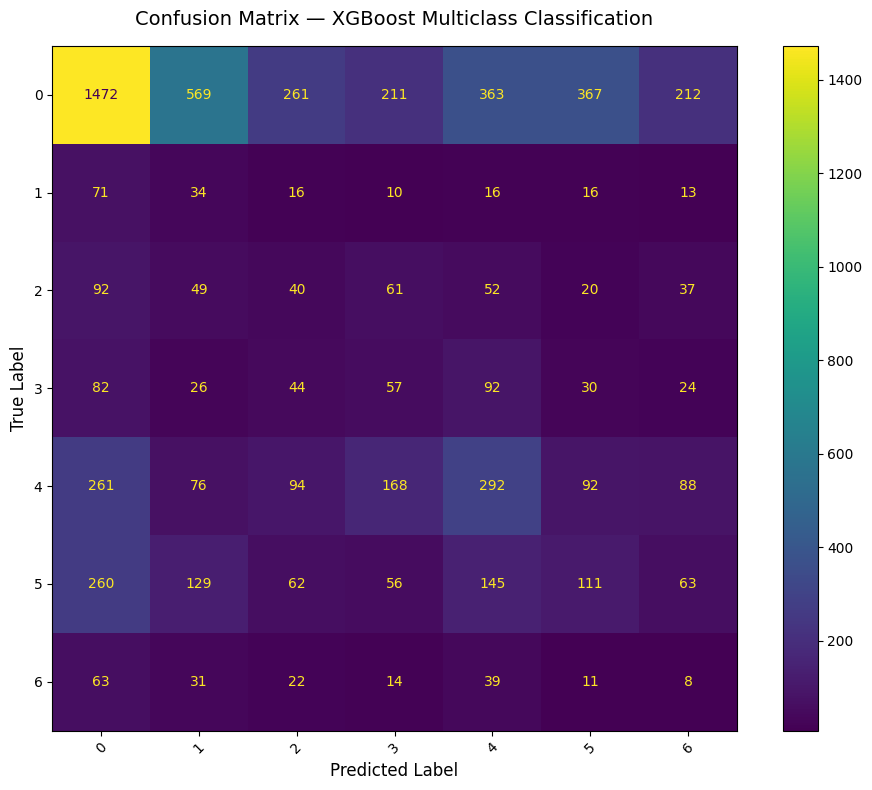

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier  # XGBoost classifier

# Get the class names from the unique values in the target variable
# Ensure class_names reflects the actual unique labels in y_test
class_names = np.unique(y_Bor_test).astype(str)

# 3. Train a multiclass classification model using XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(np.unique(y_Bor_train)), # Number of target classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model.fit(X_Bor_train, y_Bor_train)

# 4. Make predictions on the test set
y_pred = model.predict(X_Bor_test)

# 5. Calculate the confusion matrix
cm = confusion_matrix(y_Bor_test, y_pred)

# 6. Visualize the confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='viridis', ax=ax)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix — XGBoost Multiclass Classification', fontsize=14, pad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# SHAP model

In [36]:
! pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.2 MB/s eta 0:00:00


✅ Data cleaned. All numeric columns confirmed: 15
✅ SMOTE applied. Balanced class counts:
ciafl
0    11516
3    11516
2    11516
4    11516
5    11516
1    11516
6    11516
Name: count, dtype: int64
✅ Selected 15 features via Boruta.
✅ XGBoost training complete.

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.41      0.43      3454
           1       0.49      0.66      0.56      3455
           2       0.44      0.45      0.45      3455
           3       0.45      0.50      0.47      3455
           4       0.41      0.31      0.35      3455
           5       0.40      0.30      0.34      3455
           6       0.51      0.55      0.53      3455

    accuracy                           0.45     24184
   macro avg       0.45      0.45      0.45     24184
weighted avg       0.45      0.45      0.45     24184



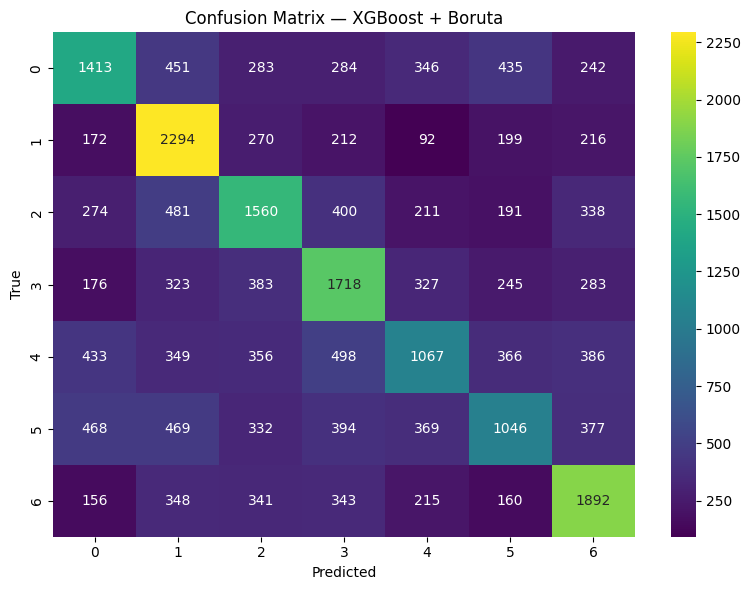

In [ ]:
# ============================================================
# 📘 FINAL PIPELINE: Boruta + XGBoost + SHAP (Multiclass + Imbalance)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1️⃣ Load and Prepare Data
# ============================================================

# Example: replace with your dataframe
# df = pd.read_csv("your_dataset.csv")

target = "ciafl"

df1 = df.drop(columns=["respondent_currently_working","child_sex","source_water","householdhead_sex","no_visits", "bmi_cat"])
X = df1.drop(columns=[target])
y = df1[target]

# Encode target if not numeric
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# ============================================================
# 2️⃣ Clean any hidden list-like string columns (the source of your ValueError)
# ============================================================

def clean_list_strings(df):
    def fix_cell(x):
        if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
            try:
                values = np.array(eval(x), dtype=float)
                return float(np.mean(values))
            except:
                return np.nan
        return x
    return df.applymap(fix_cell)

X = clean_list_strings(X)
X = X.apply(pd.to_numeric, errors='coerce')

print("✅ Data cleaned. All numeric columns confirmed:", X.select_dtypes('number').shape[1])

# ============================================================
# 3️⃣ Handle Imbalanced Multiclass Data
# ============================================================

sm = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = sm.fit_resample(X, y)
print("✅ SMOTE applied. Balanced class counts:")
print(pd.Series(y_res).value_counts())

# ============================================================
# 4️⃣ Boruta Feature Selection
# ============================================================

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
boruta_selector.fit(X_res.values, y_res.values)

selected_features = X.columns[boruta_selector.support_]
print(f"✅ Selected {len(selected_features)} features via Boruta.")
X_selected = X_res[selected_features]

# ============================================================
# 5️⃣ Train-Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# ============================================================
# 6️⃣ Train XGBoost Multiclass Model
# ============================================================

model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_res)),
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)
model.fit(X_train, y_train)
print("✅ XGBoost training complete.")

# ============================================================
# 7️⃣ Evaluate Model
# ============================================================

y_pred = model.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix (nice visualization)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — XGBoost + Boruta")
plt.tight_layout()
plt.show()

# ============================================================
# 8️⃣ SHAP Explainability
# ============================================================

print("\n🔍 Computing SHAP values (this may take a minute)...")
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# --- Global Importance (Bar Plot)
plt.title("Global Feature Importance (Mean |SHAP Value|)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# --- SHAP Beeswarm Summary
plt.title("Feature Impact & Direction (SHAP Summary)")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

# --- Top 10 Important Features Table
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP|': shap_abs_mean
}).sort_values(by='Mean |SHAP|', ascending=False)
print("\n🏆 Top 10 Most Important Features:")
print(importance_df.head(10))
